In [4]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import xgboost as xgb

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt 
%matplotlib inline 

# original test

In [3]:
# read date
df = pd.read_csv('1_taipei_purged.csv')

df = df.drop(['address', 'latitude', 'longitude', 'style', 'district'], axis=1)
df.loc[:, 'date'] = df.loc[:, 'date'] % 100 + (df.loc[:, 'date'] // 100 - 2013 ) * 12

In [5]:
# train
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.25,
    reg_alpha=0.3,
    reg_lambda=0.09,
    gamma=0.05,
    max_depth=13
)

X = df.drop(['total_price', 'avg'], axis=1)
y = df[['total_price']]

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=2)

# original
r2_sum, mae_sum = 0, 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = round(r2_score(y_test, y_pred), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2_sum += r2
    mae_sum += mae
    
    print(f'R2: {r2}, MAE: {mae}')
    
print(f'\nR2: {round(r2_sum/folds, 4)}, MAE: {round(mae_sum/folds, 4)}')

R2: 0.6508, MAE: 342.6821
R2: 0.7479, MAE: 343.4732
R2: 0.7565, MAE: 343.9806
R2: 0.8129, MAE: 342.5968
R2: 0.7068, MAE: 341.3638

R2: 0.735, MAE: 342.8193


# join data and test

In [6]:
# read data and join
df = pd.read_csv('1_taipei_purged.csv')

dfp = pd.read_csv('pop.csv')
dfp = dfp[['year', 'district', 'pop', 'sex_ratio', 'in', 'out', 'growth', 'marry_rate']]

dff = pd.read_csv('AllFinancialCols.csv')
dff = dff[['date', 'load_archi', 'load_house', 'M1B', 'income_rate']]

df['district'] = df['district'].str[3:5]
df['year'] = df['date'] // 100

df = pd.merge(df, dfp, on=['year', 'district'])
df = pd.merge(df, dff, on='date')

df = df.drop(['address', 'latitude', 'longitude', 'style', 'percent', 'management', 'district', 'year'], axis=1)
df.loc[:, 'date'] = df.loc[:, 'date'] % 100 + (df.loc[:, 'date'] // 100 - 2013 ) * 12

In [8]:
# train
X = df.drop(['total_price', 'avg'], axis=1)
y = df[['total_price']]

col_name = X.columns

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

# join data
r2_sum, mae_sum = 0, 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = round(r2_score(y_test, y_pred), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2_sum += r2
    mae_sum += mae
    
    print(f'R2: {r2}, MAE: {mae}')
    
print(f'\nR2: {round(r2_sum/folds, 4)}, MAE: {round(mae_sum/folds, 4)}')

R2: 0.8807, MAE: 202.3439
R2: 0.7479, MAE: 203.174
R2: 0.9028, MAE: 199.0425
R2: 0.8612, MAE: 202.6294
R2: 0.7363, MAE: 202.6426

R2: 0.8258, MAE: 201.9665


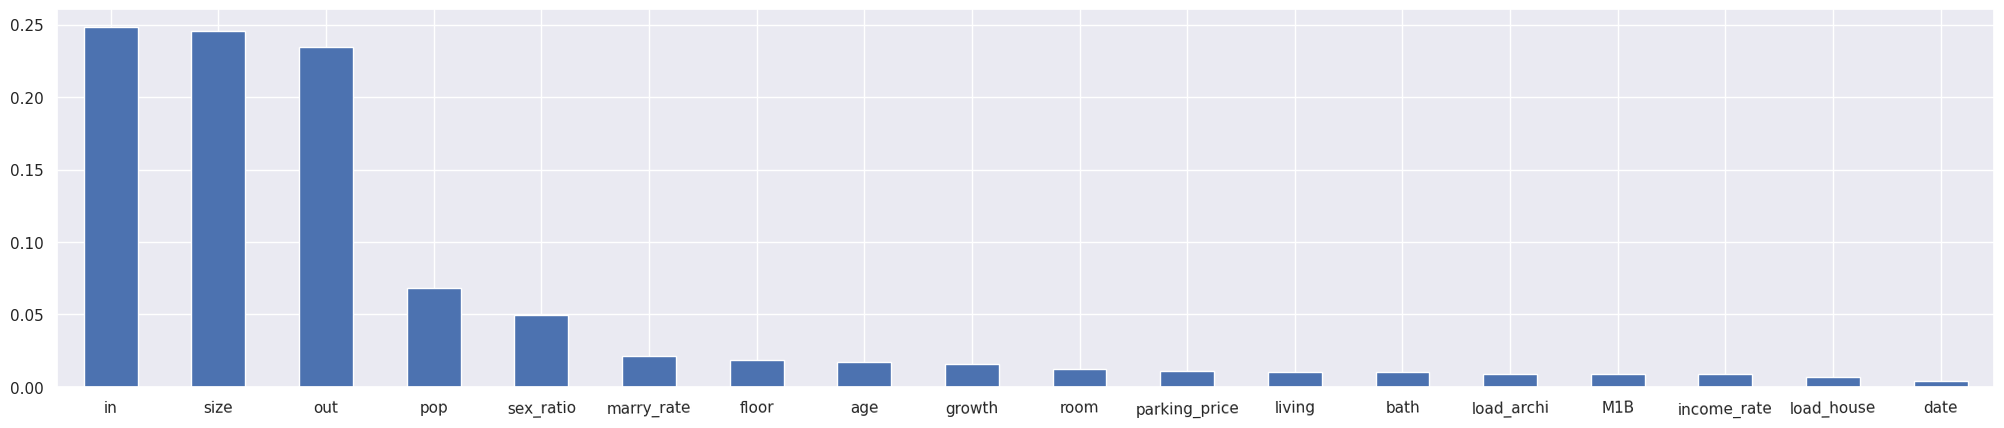

In [9]:
# show importances
importances = dict(zip(col_name, model.feature_importances_))

ser = pd.Series(importances)
ser = ser.sort_values(ascending=False)
def topk(x, k): return x.head(k)
ser = topk(ser, 20)

# 變數重要性
fig, ax = plt.subplots(dpi=100, figsize=(25,5))
ser.plot(kind='bar', ax=ax, rot=1)
plt.savefig("xgb_join.png", bbox_inches="tight", pad_inches=0.05)

# heatmap

In [12]:
# read data and join
df = pd.read_csv('1_taipei_purged.csv')

dfp = pd.read_csv('pop.csv')
dfp = dfp[['year', 'district', 'pop', 'sex_ratio', 'in', 'out', 'growth', 'marry_rate']]

dff = pd.read_csv('AllFinancialCols.csv')
dff = dff[['date', 'load_archi', 'load_house', 'M1B', 'income_rate']]

df['district'] = df['district'].str[3:5]
df['year'] = df['date'] // 100

df = pd.merge(df, dfp, on=['year', 'district'])
df = pd.merge(df, dff, on='date')

df = df.drop(['address', 'latitude', 'longitude', 'style', 'percent', 'management', 'district', 'year'], axis=1)
df.loc[:, 'date'] = df.loc[:, 'date'] % 100 + (df.loc[:, 'date'] // 100 - 2013 ) * 12

df['price'] = df['total_price']

df.drop(['total_price', 'avg'], axis=1, inplace=True)

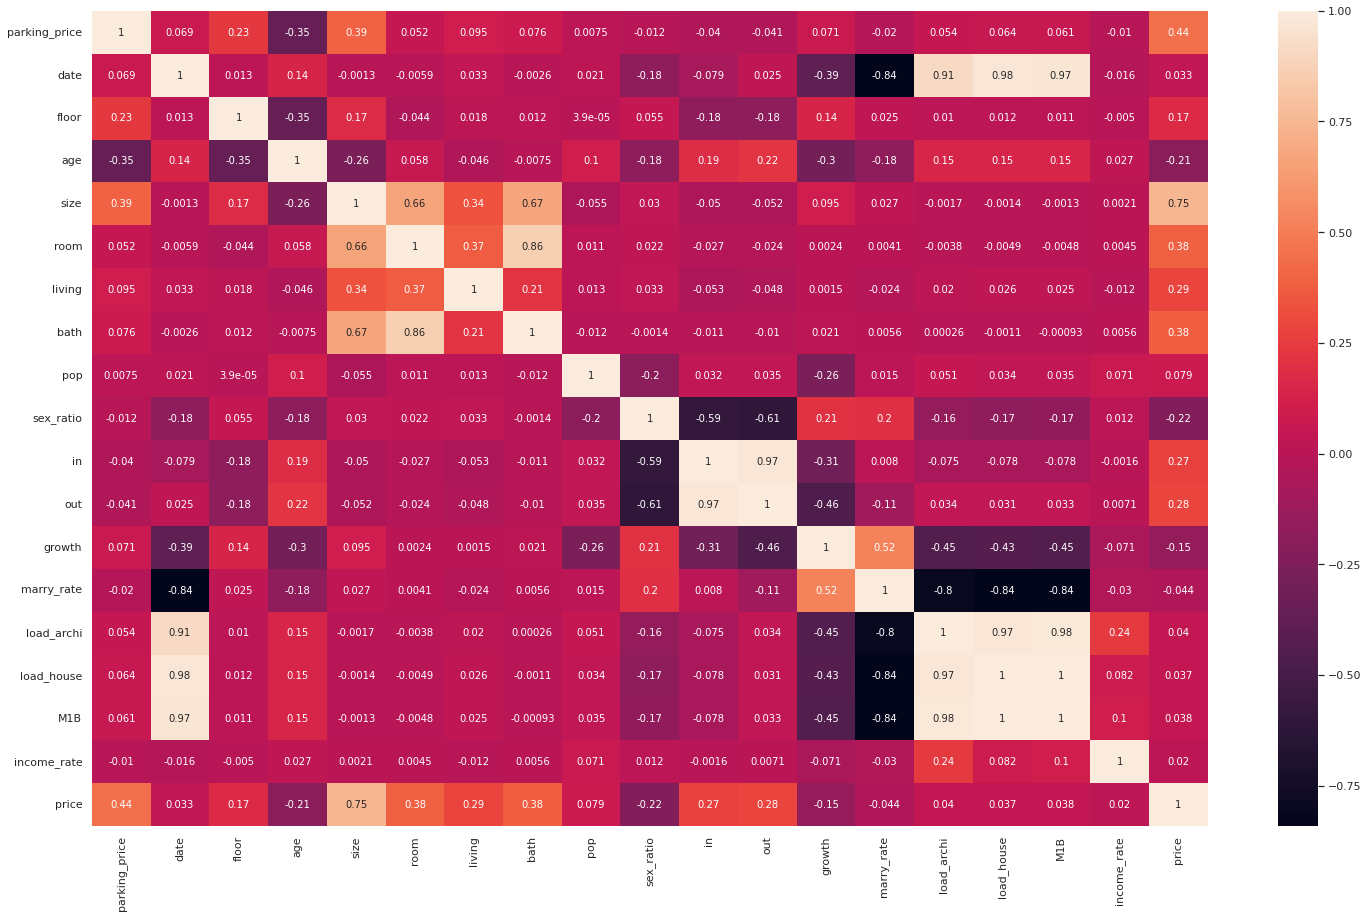

In [13]:
# show heatmap
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True)
plt.savefig("heatmap.png")